In [3]:
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Dropout, Flatten

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import os


In [4]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"dataset"
CATEGORIES = ["with_mask", "without_mask"]


In [5]:
# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        data.append(image)
        labels.append(category)


[INFO] loading images...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)


In [7]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


In [ ]:
# # load the MobileNetV2 network, ensuring the head FC layer sets are left off
# baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# # construct the head of the model that will be placed on top of the
# # the base model
# headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(128, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(2, activation="softmax")(headModel)

# # place the head FC model on top of the base model (this will become the actual model we will train)
# model = Model(inputs=baseModel.input, outputs=headModel)

# # loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
# for layer in baseModel.layers:
# 	layer.trainable = False


In [8]:
# creating the model
model = Sequential()
model.add(Conv2D(64,(3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(len(CATEGORIES)))
model.add(Activation('softmax'))


In [9]:
# compile our model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS),
              metrics=["accuracy"])


[INFO] compiling model...


In [10]:
# train the network
print("[INFO] training model...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


[INFO] training model...
Epoch 1/20
95/95 [==============================] - 49s 411ms/step - loss: 0.9341 - accuracy: 0.5257 - val_loss: 0.6865 - val_accuracy: 0.6962
Epoch 2/20
95/95 [==============================] - 35s 368ms/step - loss: 0.5524 - accuracy: 0.7818 - val_loss: 0.2805 - val_accuracy: 0.9140
Epoch 3/20
95/95 [==============================] - 35s 369ms/step - loss: 0.3829 - accuracy: 0.8540 - val_loss: 0.2719 - val_accuracy: 0.9283
Epoch 4/20
95/95 [==============================] - 35s 371ms/step - loss: 0.3312 - accuracy: 0.8790 - val_loss: 0.2332 - val_accuracy: 0.9244
Epoch 5/20
95/95 [==============================] - 35s 369ms/step - loss: 0.2986 - accuracy: 0.8939 - val_loss: 0.2024 - val_accuracy: 0.9400
Epoch 6/20
95/95 [==============================] - 35s 370ms/step - loss: 0.2787 - accuracy: 0.8998 - val_loss: 0.1937 - val_accuracy: 0.9413
Epoch 7/20
95/95 [==============================] - 36s 380ms/step - loss: 0.2652 - accuracy: 0.9005 - val_loss: 0.23

In [11]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
24/24 [==============================] - 2s 98ms/step
              precision    recall  f1-score   support

   with_mask       0.94      0.98      0.96       383
without_mask       0.98      0.94      0.96       384

    accuracy                           0.96       767
   macro avg       0.96      0.96      0.96       767
weighted avg       0.96      0.96      0.96       767



In [12]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


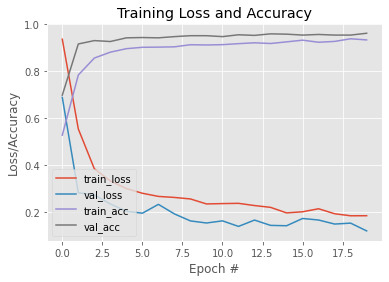

In [13]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")